## Fitting and Evaluating the Final Model

We now fit the final `GradientBoostingClassifier` model we arrived to in the last notebook on the full training data and evaluate on the test data. We'll take a look at the model's most important features and assess its performance. Then we'll evaulate the model across different decision thresholds to assess the impact of these thresholds.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

import itertools

from copy import copy, deepcopy
import pickle

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score, classification_report
from sklearn.model_selection import train_test_split

In [2]:
with open('statcast_full_clean.pkl', 'rb') as p:
    all_data = pickle.load(p)

We use the same data as in the previous notebook, and split it into the same train and test sets (again, we are training on the 2015 through 2018 seasons, with the test set being the 2019 season):

In [3]:
train_data = all_data[all_data['game_year'] < 2019]
test_data = all_data[all_data['game_year'] == 2019]

In [4]:
X_train = train_data.drop(columns=['game_date', 'game_year', 'home_team', 'away_team', 'def_team', 'at_bat_number', 'events', 'hit'])
X_test = test_data.drop(columns=['game_date', 'game_year', 'home_team', 'away_team', 'def_team', 'at_bat_number', 'events', 'hit'])

y_train = train_data['hit']
y_test = test_data['hit']

In [5]:
print(X_train.shape)
print(X_test.shape)

(506346, 15)
(123875, 15)


Now, let's fit the final model from the previous notebook on the training data, and evaluate on test:

In [6]:
gb_final = GradientBoostingClassifier(n_estimators=40, max_depth=10, max_features=8, learning_rate=0.15, random_state=42, n_iter_no_change=5, tol=.01)
gb_final.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.15, max_depth=10, max_features=8,
                           n_estimators=40, n_iter_no_change=5, random_state=42,
                           tol=0.01)

In [7]:
y_pred = gb_final.predict(X_test)

In [8]:
print(classification_report(y_test, y_pred))
print('F2 Score: ', fbeta_score(y_test, y_pred, beta=2))
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.90      0.88     81871
           1       0.79      0.73      0.76     42004

    accuracy                           0.84    123875
   macro avg       0.83      0.82      0.82    123875
weighted avg       0.84      0.84      0.84    123875

F2 Score:  0.7438120366880262
Recall:  0.7328825826111799
Precision:  0.7909964540829436


We see that the model has performed better with outs than hits, and for hits, Precision is better than Recall despite having prioritized recall by using `fbeta_score` with `beta=2`. The `fbeta_score` seems to track with what we observed in some of the training process detailed in the previous notebook, the out-of-sample performance seems to not improve much beyond values between 0.70 - 0.75.

Now, we'll construct the confusion matrix for our predictions to supplement these numbers:

In [9]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Blues):
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.xticks(range(0,2))
    plt.yticks(range(0,2))
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

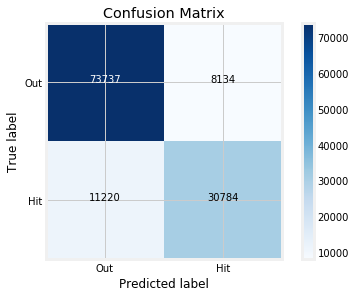

In [10]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,cmap=plt.cm.Blues)
plt.xticks([0,1], ['Out', 'Hit'])
plt.yticks([0,1], ['Out', 'Hit']);

Indeed we see roughly 3 times as many actual hits correctly predicted (true positives TP) as those misclassified as outs (false negatives FN), with close to 4 times as many actual hits correctly predicted (TP) as outs misclassified as hits (false positive FP) -- as indicated by our recall and precision scores.

Before taking a look at how we might adjust the decision threshold of our model to increase TPs without increasing FPs too much, let's first look at the 10 (albeit out of 15) most important features of the model:

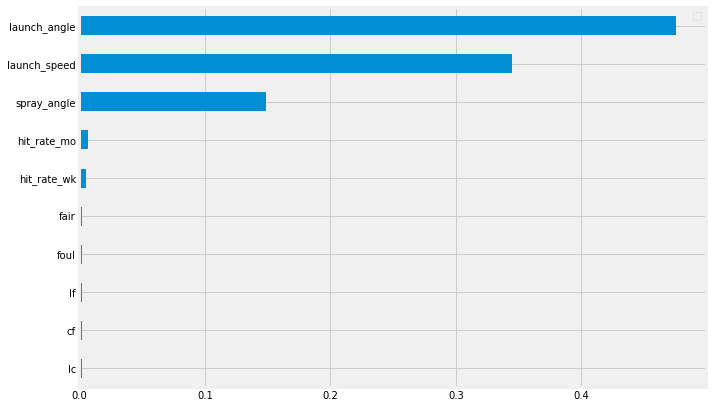

In [11]:
feat_imp = gb_final.feature_importances_
features = X_train.columns.values
zipped = zip(features, feat_imp)
zipped = [z for z in zipped if z[1] > 0]
feat_imp_sort = sorted(list(zipped), key=lambda tup: abs(tup[1]))[-10:]

feat_imp_df = pd.DataFrame.from_records(feat_imp_sort)
feat_imp_df.plot.barh(figsize=(10,7))
plt.legend([])
plt.yticks(range(0, len(feat_imp_df)), feat_imp_df[0]);

As expected (based on our EDA from the previous notebook), the features describing the contact of a batted ball are overwhelmingly more important in discriminating between hits and outs. Of the marginally important remaining features, the two "hit rate" features -- attempting to quantify team defensive performnce -- are the next most important, first the "larger sample" monthly rate, then the weekly rate. The remaining "important" stadium dimension features (which are likely negligibly more important than those not shown above) all deal with the area of fair/foul territory and left field dimensions -- so perhaps there is marginal information gain from stadium oddities like the [very large and very small fair territories of Coors Field and Fenway Park, respectively](https://www.businessinsider.com/chart-major-league-baseball-ballpark-sizes-2014-3), the extremely [large foul territory of the Oakland Coliseum](https://bleacherreport.com/articles/615282-the-20-most-interesting-ballpark-quirks-in-mlb-history), or [The Green Monster](https://en.wikipedia.org/wiki/Green_Monster).

Now let us evaluate the impact of adjusting the decision threshold of the model on precision and recall. We'll cycle through all thresholds between .05 and .95 (including the default threshold of 0.5 leading to the results above) and compute the precision and recall when the model's `predict_proba` for the positive class (`hit = 1`) is higher than a a threshold value:

In [12]:
thresh = np.linspace(.05, .95, 91)
precisions = []
recalls = []
for thr in thresh:
    pred = [1 if y >= thr else 0 for y in gb_final.predict_proba(X_test)[:,1]]
    precisions.append(precision_score(y_test, pred))
    recalls.append(recall_score(y_test, pred))
    print(f'Done with threshold = {str(thr)}')

Done with threshold = 0.05
Done with threshold = 0.06
Done with threshold = 0.07
Done with threshold = 0.08
Done with threshold = 0.09
Done with threshold = 0.09999999999999999
Done with threshold = 0.10999999999999999
Done with threshold = 0.12
Done with threshold = 0.13
Done with threshold = 0.13999999999999999
Done with threshold = 0.14999999999999997
Done with threshold = 0.15999999999999998
Done with threshold = 0.16999999999999998
Done with threshold = 0.18
Done with threshold = 0.19
Done with threshold = 0.19999999999999996
Done with threshold = 0.20999999999999996
Done with threshold = 0.21999999999999997
Done with threshold = 0.22999999999999998
Done with threshold = 0.24
Done with threshold = 0.24999999999999994
Done with threshold = 0.25999999999999995
Done with threshold = 0.26999999999999996
Done with threshold = 0.27999999999999997
Done with threshold = 0.29
Done with threshold = 0.3
Done with threshold = 0.30999999999999994
Done with threshold = 0.31999999999999995
Done 

In [13]:
list(zip(thresh, recalls, precisions))

[(0.05, 0.9937624988096372, 0.4364218054074399),
 (0.06, 0.9894057708789639, 0.4575420286025696),
 (0.07, 0.9843110179982859, 0.4776124575468429),
 (0.08, 0.9793353013998667, 0.494381482327208),
 (0.09, 0.973788210646605, 0.5090033474781916),
 (0.09999999999999999, 0.9682411198933435, 0.5223612217113206),
 (0.10999999999999999, 0.9626226073707266, 0.5353865709783775),
 (0.12, 0.9571231311303685, 0.5474264705882353),
 (0.13, 0.9515522331206552, 0.5582652419861722),
 (0.13999999999999999, 0.9466003237786877, 0.5690548431417449),
 (0.14999999999999997, 0.9412913055899438, 0.5787008577032289),
 (0.15999999999999998, 0.9355061422721646, 0.5878700836288018),
 (0.16999999999999998, 0.9297924007237406, 0.5968153547578661),
 (0.18, 0.9239834301495096, 0.6050699218932697),
 (0.19, 0.9184839539091515, 0.6132570338578922),
 (0.19999999999999996, 0.9127225978478241, 0.6213010080057044),
 (0.20999999999999996, 0.9077706885058566, 0.6295819298593224),
 (0.21999999999999997, 0.9017474526235597, 0.6374

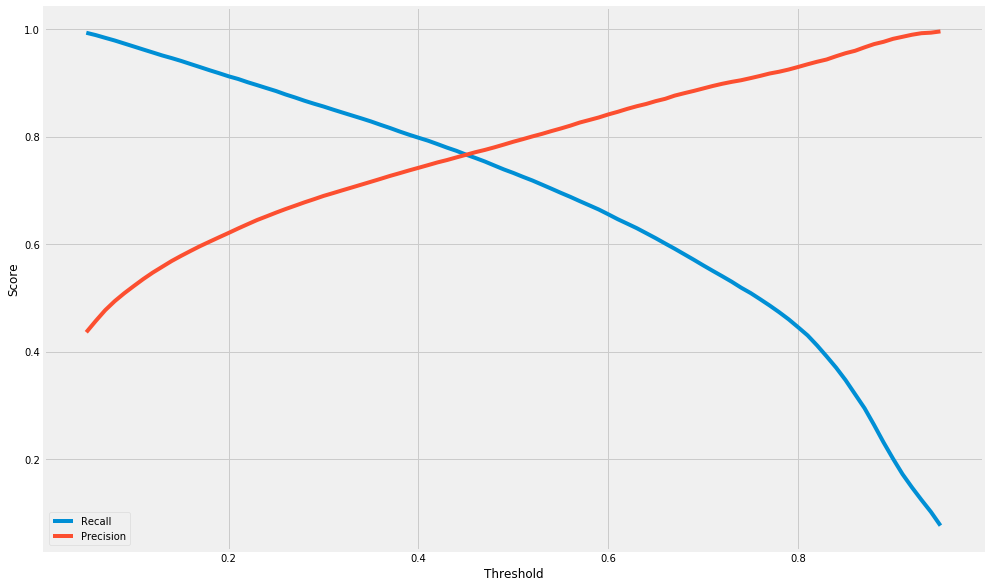

In [14]:
plt.figure(figsize=(15, 10))
plt.plot(thresh, recalls, label='Recall')
plt.plot(thresh, precisions, label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend();

The intersection point of precision and recall values occurs at a threshold of ~0.45. We'll use this as our new decision threshold and evaluate the predictions resulting from this adjustment:

In [15]:
y_pred_thr = [1 if y >= 0.45 else 0 for y in gb_final.predict_proba(X_test)[:,1]]
print(classification_report(y_test, y_pred_thr))
print('F2 Score: ', fbeta_score(y_test, y_pred_thr, beta=2))
print('Recall: ', recall_score(y_test, y_pred_thr))
print('Precision: ', precision_score(y_test, y_pred_thr))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88     81871
           1       0.77      0.77      0.77     42004

    accuracy                           0.84    123875
   macro avg       0.82      0.82      0.82    123875
weighted avg       0.84      0.84      0.84    123875

F2 Score:  0.7669785046061558
Recall:  0.7670698028759165
Precision:  0.7666135287539556


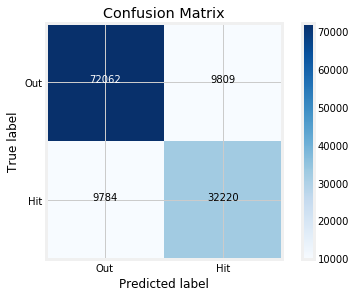

In [16]:
cm = confusion_matrix(y_test, y_pred_thr)
plot_confusion_matrix(cm,cmap=plt.cm.Blues)
plt.xticks([0,1], ['Out', 'Hit'])
plt.yticks([0,1], ['Out', 'Hit']);

It's a mild improvement in `fbeta_score` by about 2%, mostly from a near 3% improvement in recall offset by a similar but smaller decline in precision. We see a bit higher than a  3:1 ratio in TPs to both FNs and FPs now.

Let's now add these predictions to the larger test data DataFrame and go a little deeper into analyzing the model's predictions.

In [17]:
test_data = test_data.reset_index().drop(columns='index')

In [18]:
test_data['pred'] = y_pred_thr

Next, we'll determine whether each prediction is a true positive (TP), true negative (TN) false positive (FN), or false positive (FP) and add it to the DataFrame. As we have not previously indicated, TN is a correctly predicted out:

In [19]:
def pred_result(row):
    if row['hit'] + row['pred'] == 2:
        return 'TP'
    elif row['hit'] + row['pred'] == 0:
        return 'TN'
    else:
        return 'FP' if row['hit'] == 0 else 'FN'

In [20]:
test_data['pred_result'] = test_data.apply(lambda r: pred_result(row=r), axis=1)

### Predictions for Hit and Out Types

Let's first look at the predictions for actual hits:

In [21]:
hit_events = ['single', 'double', 'triple', 'home_run']

In [22]:
test_data_onlyhits = test_data[test_data['events'].isin(hit_events)]

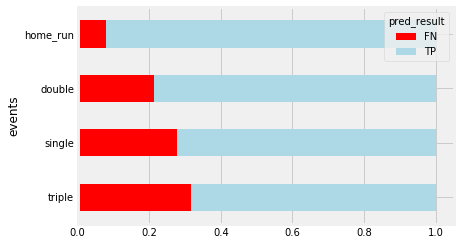

In [23]:
pd.crosstab(test_data_onlyhits['events'], test_data_onlyhits['pred_result'], normalize='index')\
    .sort_values(by='TP').plot.barh(stacked=True, color=('red','lightblue'));

We see that the true hits most often identifed correctly are home runs, with triples being incorrectly identified most frequently. The result for home runs is not surprising as these tend to occur in a [very limited band of launch angle/exit velocity pairs](https://fivethirtyeight.com/features/the-new-science-of-hitting/), which by observation appear to feature more true hits than outs in the "pair plots" from the previous notebook. The result for triples seems odd, but perhaps there are a number of triples whose combination of launch angle, exit velocity (`launch_speed`) and `spray_angle` are more out-like but result from a defensive misplay not scored an error?  

Let's now look at predictions for actual outs. We'll filter out some of the less frequently occurring out events.

In [24]:
test_data_onlyouts = test_data[~test_data['events'].isin(hit_events)]

In [25]:
test_data_onlyouts.groupby("events").size()

events
double_play                    403
field_out                    72244
fielders_choice_out            287
force_out                     3560
grounded_into_double_play     3451
sac_bunt                       772
sac_bunt_double_play             3
sac_fly                       1137
sac_fly_double_play             11
triple_play                      3
dtype: int64

In [26]:
test_data_onlyouts = test_data_onlyouts[~test_data_onlyouts['events'].isin(['sac_bunt_double_play', 'sac_fly_double_play', 'triple_play'])]

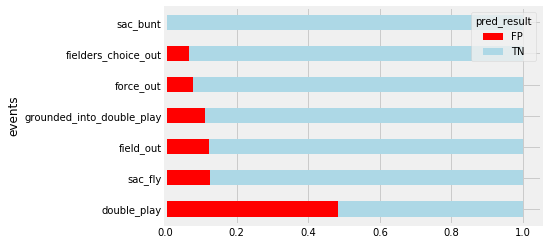

In [27]:
pd.crosstab(test_data_onlyouts['events'], test_data_onlyouts['pred_result'], normalize='index')\
    .sort_values(by='TN').plot.barh(stacked=True, color=('red','lightblue'));

Sacrifice bunts are clearly the most correctly identified type of out, while double plays are by far the least correctly identified out. The former makes sense as sacrifice bunts are often the lightest contact, shortest distance batted ball events which are basically intentional outs. As for double plays, it could be that many such plays are the result of well-hit batted balls whose combination of `launch_speed`, `launch_angle` and `spray angle` either allow infielders to more quickly turn a double play (if a groundball) or are perceived to be hits by baserunners who are then doubled off (if a line drive or flyball).

Let's now take a look at the distribution of these three features for all four types of prediction results:

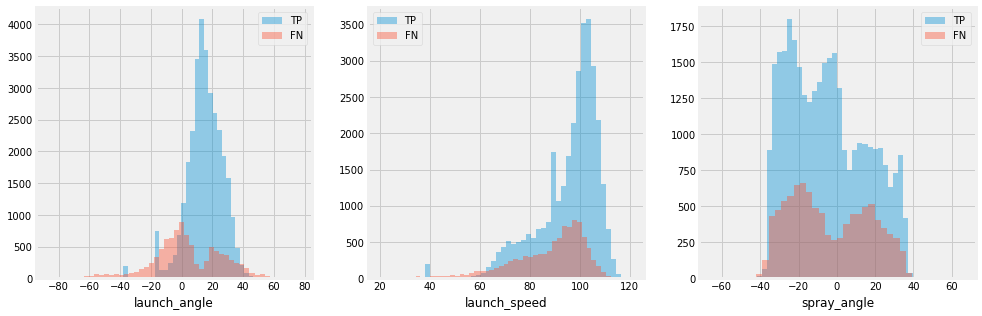

In [28]:
plt.figure(figsize=(15,5))
for i, col in enumerate(['launch_angle', 'launch_speed', 'spray_angle']):
    plt.subplot(1, 3, i+1)
    sns.distplot(test_data_onlyhits.groupby('pred_result')[col].get_group('TP'), kde=False, label='TP');
    sns.distplot(test_data_onlyhits.groupby('pred_result')[col].get_group('FN'), kde= False, label='FN');
    plt.legend();

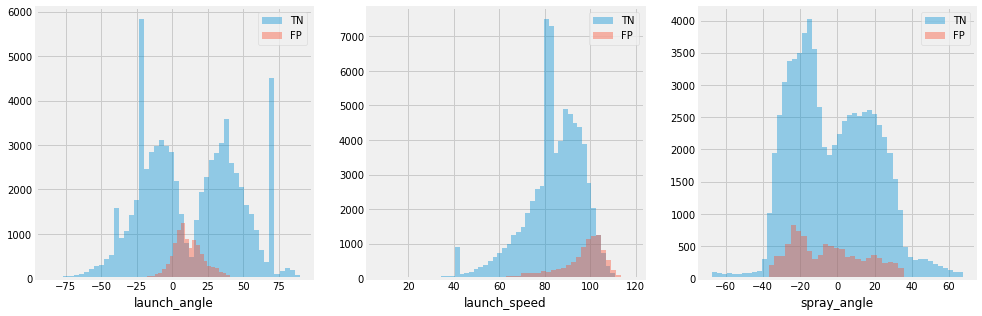

In [29]:
plt.figure(figsize=(15,5))
for i, col in enumerate(['launch_angle', 'launch_speed', 'spray_angle']):
    plt.subplot(1, 3, i+1)
    sns.distplot(test_data_onlyouts.groupby('pred_result')[col].get_group('TN'), kde=False, label='TN');
    sns.distplot(test_data_onlyouts.groupby('pred_result')[col].get_group('FP'), kde= False, label='FP');
    plt.legend();

It looks like incorrectly identified outs tend to occur in ranges of `launch_angle` and `launch_speed` where there tend to be fewer hits, and incorrectly identified hits tend to occur in `launch_angle` and `launch_speed` ranges with fewer outs. Nothing quite as conclusive can really be drawn about `spray_angle` although there appear to be a few ranges of values with a few misindentified outs and nearly zero true hits. These results point to the potential absence of some stadium and defensive factors not accounted for in the current model.

#### Closer Look at Triples

Let's now break down triples by the three contact features:

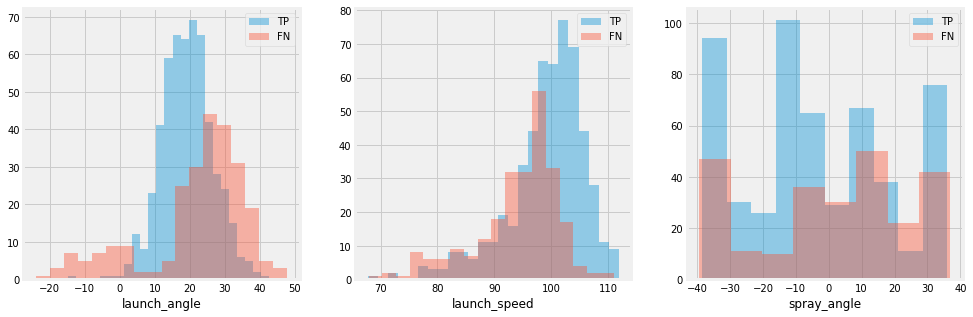

In [30]:
triples = test_data[test_data['events'] == 'triple']
plt.figure(figsize=(15,5))
for i, col in enumerate(['launch_angle', 'launch_speed', 'spray_angle']):
    plt.subplot(1, 3, i+1)
    sns.distplot(triples.groupby('pred_result')[col].get_group('TP'), kde=False, label='TP');
    sns.distplot(triples.groupby('pred_result')[col].get_group('FN'), kde= False, label='FN');
    plt.legend();

Generally, it apppears that many of the misclassified triples have `launch_angle` values on the extreme ends (so either groundballs or flyballs that more resemble pop-ups) and lower `launch_speed` values (so not as well-hit), which aligns with the earlier hypothesis that a not insignifacnt amount of these are the result of misplays. What we can glean from the `spray_angle` values is less clear but the presence of misclassified triples associated with more positive values might indicate that these are the result of defensive positioning (a batter being played to pull who hits it the other way perhaps).

#### Closer Look at Double Plays

And now the same for double plays:

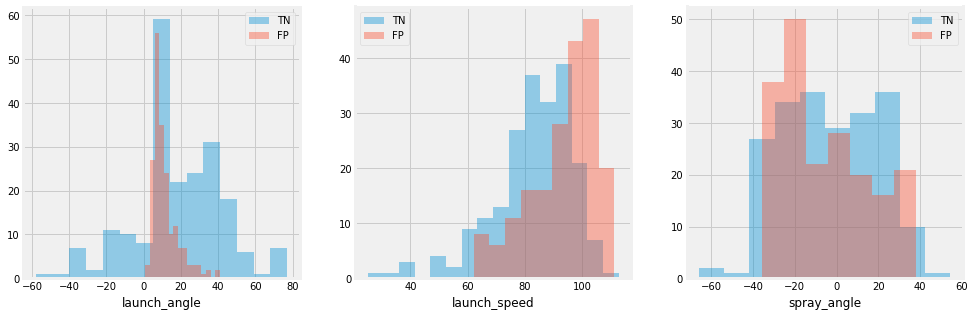

In [31]:
double_plays = test_data[test_data['events'] == 'double_play']
plt.figure(figsize=(15,5))
for i, col in enumerate(['launch_angle', 'launch_speed', 'spray_angle']):
    plt.subplot(1, 3, i+1)
    sns.distplot(double_plays.groupby('pred_result')[col].get_group('TN'), kde=False, label='TN');
    sns.distplot(double_plays.groupby('pred_result')[col].get_group('FP'), kde= False, label='FP');
    plt.legend();

It appears that many of these misclassified double plays are associated with higher values of `launch_speed` and to a degree at values of `launch_angle` in the 0-10 degree range -- perhaps confirming our earlier hypotheses. That these occur across a wide range of `spray_angle` values could lend to some explanations based on defensive positioning as well (well-hit grounders into a shift, for example).

### Predictions by Defensive Team

Let's now look at the predictions by `def_team`, the team playing defense for each particular batted ball. We'll start looking at the true hits and then the true outs. For true hits, we'd expect the [better defensive teams](https://www.fangraphs.com/leaders.aspx?pos=all&stats=fld&lg=all&qual=0&type=1&season=2019&month=0&season1=2019&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=&enddate=) to have fewer misclassifications (with the reverse being true for the worse defensive teams), since hits incorrectly classified as outs are generally less hit-like. For true outs, we might expect the opposite to be true (remember that outs misclassified as hits tend to not share characteristics with other outs), in that better defenses might convert more batted balls expected to be hits into outs.

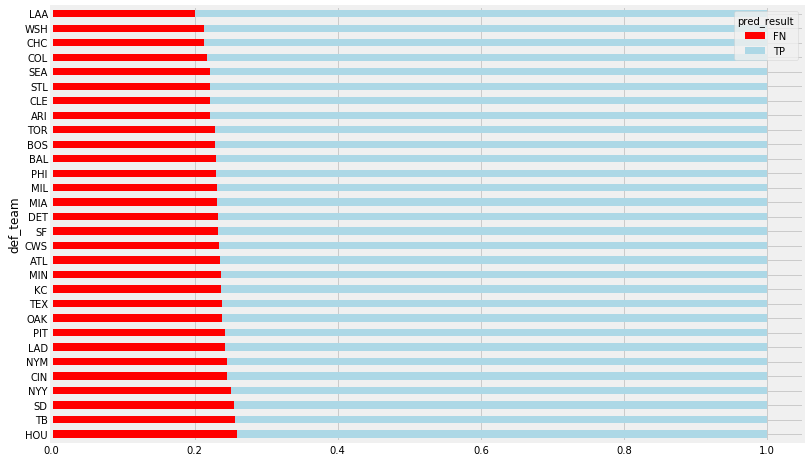

In [32]:
pd.crosstab(test_data_onlyhits['def_team'], test_data_onlyhits['pred_result'], normalize='index')\
    .sort_values(by='TP').plot.barh(stacked=True, color=('red','lightblue'), figsize=(12,8));

So, we definitely see some of the better defensive teams up top -- Cubs (`CHC`), Angels (`LAA`) and Cardinlas (`STL`) -- and some of the worse defensive teams at the bottom -- Reds (`CIN`), Pirates (`PIT`) and Mets (`NYM`) in particular. But we also see some poor defensive teams near the top -- Rockies (`COL`) and Mariners (`SEA`) -- and some good defensive teams at the bottom -- Padres (`SD`) and Astros (`HOU`). What gives?

Certainly, the quality of the team's defense alone doesn't completely explain whether more or less true hits will be correctly predicted. Characteristics of these teams' pitching staffs also play a role. The Rockies and Mariners also have two of the worst [pitching staffs](https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=8&season=2019&month=0&season1=2019&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=2019-01-01&enddate=2019-12-31) in the league, and may give up more predictably hit-like contact. Meanwhile a team like the Astros (or the Padres) who don't give up many easily predicted hits (Astros because they had one of the better pitching staffs and Padres because their pitchers [don't give up many home runs](https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=2&season=2019&month=0&season1=2019&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=2019-01-01&enddate=2019-12-31&sort=8,d).

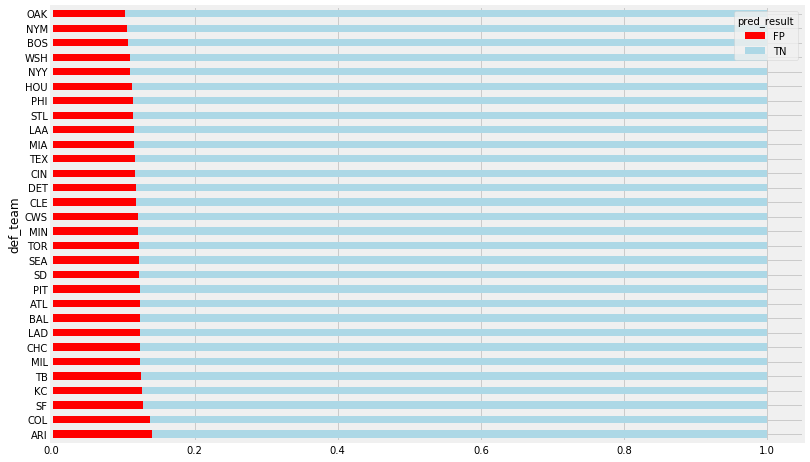

In [33]:
pd.crosstab(test_data_onlyouts['def_team'], test_data_onlyouts['pred_result'], normalize='index')\
    .sort_values(by='TN').plot.barh(stacked=True, color=('red','lightblue'), figsize=(12,8));

Looking at the true outs, the results are not what one would expect. There is still one poor defensive team, the Mets (`NYM`), near the top and some good defensive teams, like the Giants (`LAA`) and the Diamondbacks (`ARI`), are near the bottom. One thing that is true of the teams closer to the top, however, is that they tend to give up [more soft contact](https://www.fangraphs.com/leaders.aspx?pos=all&stats=pit&lg=all&qual=0&type=2&season=2019&month=0&season1=2019&ind=0&team=0,ts&rost=0&age=0&filter=&players=0&startdate=2019-01-01&enddate=2019-12-31&sort=17,d), and thus more predictably out-like contact, while the opposite tends to be true of those teams closer to the bottom.

### Predictions by Home Team

Finally, let's now look at the predictions by `home_team` for each particular batted ball. Again, we'll first look at the true hits and then the true outs. It's not quite as clear what one would expect here. For true hits, one might expect teams whose home stadiums are less hitter-friendly to end up with fewer misclassifed outs if you view them as "cheap hits" but many of these stadiums also lend themselves to not readily predictable hits (think [Oracle Park and its "Triples Alleys"](https://www.sfchronicle.com/giants/jenkins/article/Giants-removing-Triples-Alley-would-be-blasphemy-13778546.php). On the flip side, with true outs, one might expect teams who play in less hitter-friendly stadiums to find themselves with more mislassified hits, since these might be places where ["home runs go to die"](https://www.amazinavenue.com/2009/1/7/711009/citi-field-where-homeruns). However, we might also note that stadiums which are more hitter-friendly might produce more "unexpected outs" if their hitter-friendliness comes from smaller dimensions -- turning hits that fall into the outfield into outs with less outfield ground to cover.

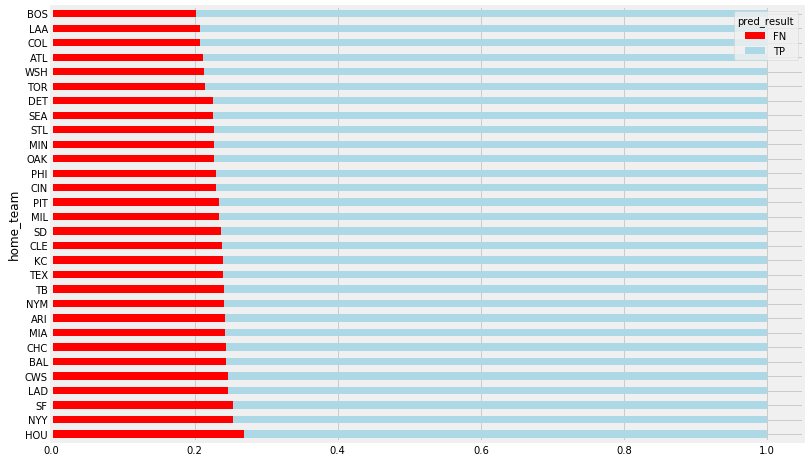

In [34]:
pd.crosstab(test_data_onlyhits['home_team'], test_data_onlyhits['pred_result'], normalize='index')\
    .sort_values(by='TP').plot.barh(stacked=True, color=('red','lightblue'), figsize=(12,8));

Just going off [2019 Park Factors](http://www.espn.com/mlb/stats/parkfactor/_/year/2019/sort/hitsFactor), we see some of the teams whose home stadiums are certainly considered better offensive environments near the top -- Red Sox (`BOS`), Rockies (`COL`), Nationals (`WSH`) and Tigers (`DET`). Towards the bottom we see some teams with less hitter-friendly home stadiums  -- certainly from the Giants (`SF`), Dodgers (`LAD`) and Marlins (`MIA`) (although Marlins Park was a bit more "hitter-friendly" in 2019). The Yankees (`NYY`) home stadium is often thought of as [a bandbox](https://www.google.com/search?q=yankee+stadium+bandbox&oq=yankee+stadium+bandbox&aqs=chrome..69i57.2825j0j7&sourceid=chrome&ie=UTF-8) but it didn't play that way in 2019. Teams in hitter-friendly stadiums like the Orioles (`BAL`) and Diamondbacks (`ARI`) show up here, however, which might be attributed to the high [Triples Park Factor](http://www.espn.com/mlb/stats/parkfactor/_/year/2019/sort/triplesFactor) of these stadiums (as with the Marlins). The Astros (`HOU`) showing up near the bottom is also confusing, but again could be a product of their pitching giving up softer contact that nevertheless end up as hits.

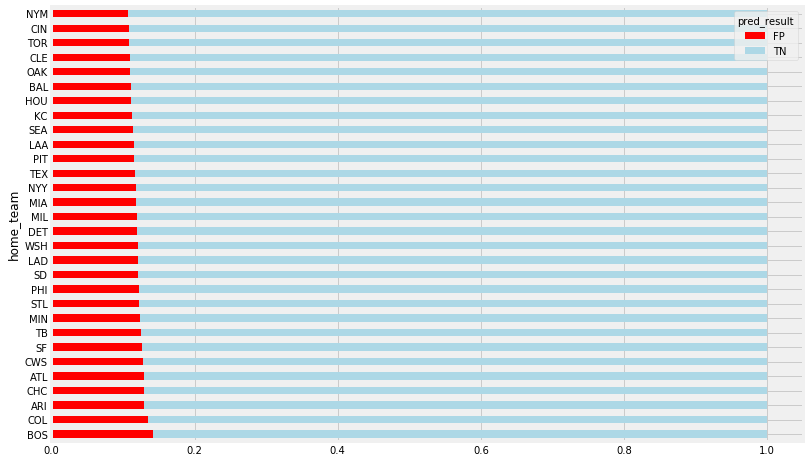

In [35]:
pd.crosstab(test_data_onlyouts['home_team'], test_data_onlyouts['pred_result'], normalize='index')\
    .sort_values(by='TN').plot.barh(stacked=True, color=('red','lightblue'), figsize=(12,8));

For true outs, we see some teams with less hitter-friendly home environments closer to the top, like the Mets (`NYM`), Indians (`CLE`) and A's (`OAK`). However, these cases might also be attributable to team pitching that either induces more soft contact (or just better defense).  Towards the bottom, we see more hitter-friendly home environments towards the bottom -- Rockies (`COL`), Red Sox (`BOS`), and Diamondbacks (`ARI`) -- some of these may be a combination of defensive and pitching tendencies as well. But there are still some hard to explain results, especially closer to the top, such as the Blue Jays (`TOR`).

## Final Discussion

* We developed a `GradientBoostingClassifier` model, using Statcast batted ball data, stadium dimensions data, and weekly and monthly batted ball hit rates for each team/season to predict whether a batted ball was a hit or an out. This model produced an F2 score of 0.767 when evaluated on 2019 batted ball data.
* Batted ball features `launch_angle`, `launch_speed` and `launch_angle` dominated as important features for the model in discriminating between hits and outs. The hit rate features figured in marginally, while the remaining stadium dimension features were not very important.
* The model performed well on "obvious" hit/out types such as home runs and sacrifice bunts, and much less well on the hit/out types which were more "peculiar" such as triples or double plays. Misclassified triples were frequently in ranges of values for `launch_angle` and `launch_speed` with fewer true hits, while misclassified double plays were frequently in ranges of values for `launch_speed` with fewer true outs (and some of the profile of `spray_angle` of these misclassified double plays hint at the need to account for positioning as well)
* Breaking down misclassification of hits and outs by defensive and home teams was inconclusive for the most part but highlighted the potential use of stadium and defensive features for each type of hit, as well as for different types of contact (softer vs harder contact)